# Friendship paradox

"Your friends have more friends than you do" on average is an interesting phenomenon that highlights a disparity between an individual's perception of their own popularity and the average popularity of their friends. This may seem counterintuitive at first, as we tend to believe that we are just as popular as our friends. However, when we consider from network perspective, it becomes clear why this paradox exists.

In this notebook, we will confirm the friendship paradox in a social network. Through this exercise, we will learn how to define and construct a network from non-network data and how to represent it.

# Preprocessing
## Data are rarely networks

Networks appear virtually every corner of the world. But these networks may not explicitly appear in data. As we will see, most data a *collection of observations.* It's your task to define and construct nodes and edges from the collection.

Let's see a raw data about social network, i.e., [Copenhagen Network study](https://www.nature.com/articles/s41597-019-0325-x). This study collected data about physical proximities of about 700 students measured based on Bluetooth signals with smartphone. Our dataset is a subset of the original dataset, and I replaced the student IDs with randomly generated names. The original data can be obtained from [here](https://figshare.com/articles/dataset/The_Copenhagen_Networks_Study_interaction_data/7267433/1?file=14000795).

Let's glance the dataset:

In [1]:
import pandas as pd

filename = "https://raw.githubusercontent.com/skojaku/adv-net-sci-course/main/data/proximity_data.csv"
contact_data_table = pd.read_csv(filename)
contact_data_table

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,user_a,user_b,rssi,#timestamp
0,Oksana Volkova,Nia Nkosi,-80,1675200
1,Sofia Costa,Ahmed Rizk,-94,1350000
2,Ayako Suzuki,Caleb Sanchez,-79,1175700
3,Hiroshi Nakamura,Saki Tanaka,-63,234600
4,Lina Al-Saleh,Zainab Nkosi,-76,1667700
...,...,...,...,...
109481,Zara Diop,-1,-93,767100
109482,Emma Mendonça,Rajesh Sharma,-99,697800
109483,Gabriel Alvarez,-1,0,844800
109484,Joshua Wright,-1,0,2062800


***note***: If you are not familiar with `pandas`, you may want to check out [Pandas for Dat aScience in 20 Minutes](https://www.youtube.com/watch?v=tRKeLrwfUgU) for how to use it.

While you may have an idea about what the columns represent, I encourage to read the README carefully whenever available. Misunderstanding data format and semantics are a common mistake, and it becomes a disastrous as the analysis moves forward.

The README attached to the data is the following:
```raw
column names:
	- timestamp
	- user A
	- user B
	- received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.
```

There are tons of networks that can be created from the same data, and the choice depends on the specific research question. Thus, it is crucial to have a well-thought-out plan in place before touching the data.

In this assignment, we want to confirm whether the friendship paradox holds true for the friendship network of the students. Although it is impossible to measure the friendships by the Bluetooth signals, it is natural to expect that friends in the same university would meet frequently in person. Based on the assumption, let's define the friendship network of the students.

## Filtering errors and noises
The raw data may contain errors, and thus, not all Bluetooth signal data observed accurately represent close physical proximity. Therefore, it is necessary to filter out certain observations. To do so, we must establish clear inclusion criteria to determine what should be considered as in-person interactions.

Here, our inclusion criteria are the following
1. Bluetooth signals must be stronger than -75dB.
2. Focus on the interactions between students who participated in the experiment.
3. Ignore the empty scans

In [2]:
# Assignment:
# Filter out the interactions.
#
# Hint: pandas.DataFrame.query is a conveient API for filtering rows based on the column values.
#
# data_table =
#

data_table = contact_data_table.query("user_b not in ('-1', '-2') and rssi != 0 and rssi > -75")
data_table


,user_a,user_b,rssi,#timestamp
3,Hiroshi Nakamura,Saki Tanaka,-63,234600
6,Sebastian Paz,Leah Watson,-58,1002300
11,Kwame Adebayo,Adnan Karim,-63,1077600
12,Naledi Khumalo,Isabella Guzman,-69,1441800
15,Rajesh Gupta,Liam Thompson,-74,1340100
...,...,...,...,...
109457,Ayesha Touré,Ravi Sharma,-68,555600
109459,Jelani Nyathi,Aisha Keita,-70,992700
109466,Ella Phillips,David Murphy,-61,2122800
109469,Abdullah Fawzi,Safiya Kamau,-70,1695600


## Data normalization

Data normalization is a crucial process that aims to eliminate redundancy, ensure completeness, and maintain consistency in the data. You can think of data normalization as constructing a solid data foundation, which ultimately determines the reliability, accuracy, and efficiency with which a castle (your project) can be built upon it.

For network analysis, it is often convenient to create two tables:
- *Node table*. This contains metadata about nodes (e.g., timestamp, size, and node IDs)
- *Edge table*. This contains metadata about edges (e.g., timestamp, weight, edge type, and edge IDs (optional)).

Let's normalize the data step by step.

### Normalizing node data

It is almost always preferred to assign unique integer IDs to individual nodes in the network.
The node table, thus, looks like:

| node_id | student_name   |
| ------- | -------------- |
| 0       | Charlotte Bell |
| 1       | Anna Volkova   |
| 2       | John Smith     |
 .....

A convenient way to generate unique IDs is to use `numpy.unique` with flag `return_inverse=True`. For instance, consider an array of names

In [3]:
names = ["Bob", "Alice", "Bob", "James", "James", "Hana"]

With `numpy.unique`, we can generate unique IDs for the names

In [4]:
import numpy as np

unique_names, name_ids = np.unique(names, return_inverse=True)
unique_names, name_ids

(array(['Alice', 'Bob', 'Hana', 'James'], dtype='<U5'),
 array([1, 0, 1, 3, 3, 2]))

where unique names is a list of unique names, and name_ids is a representation of the input array but with integer IDs, instead of the name strings.
Don't forget to flag up `return_inverse=True` otherwise you'll get only the unique_names.

In [5]:
# Assignment:
# Create the node table (in pandas DataFrame) with columns, `node_id`, and `student_name`. For example,
#
# | node_id | student_name   |
# | 0       | Charlotte Bell |
# | 1       | Anna Volkova   |
#  .....
#
# Hint:
# 1. Generate a list of all user names with duplicates
# 2. Use `numpy.unique` to generate integer IDs
# 3. Create the node_table
#
# For step 1, you may want to convert pandas.DataFrame to numpy
# See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html

# Your code ----

# all user names, with duplicates
user_a = data_table["user_a"]
user_b = data_table["user_b"]
all_users = np.concatenate([user_a, user_b])

# first find the unique names
unique_names = np.unique(all_users)
# then generate node_ids 
unique_names, name_ids = np.unique(unique_names, return_inverse=True)

# Save the table as pandas.DataFrame and name it `node_table`
node_table = pd.DataFrame({
    "node_id": name_ids.astype(int),
    "student_name": unique_names
})

node_table

,node_id,student_name
0,0,Aarav Gupta
1,1,Aarav Patel
2,2,Abdi Omar
3,3,Abdullah Fawzi
4,4,Abdullah Karim
...,...,...
644,644,Zoey Morgan
645,645,Zoey Powell
646,646,Zuri Chukwu
647,647,Zuri Kamara


In [6]:
# test
assert all(node_table["node_id"].astype(int) == node_table["node_id"])

### Normalizing edge data

The edge table consists of the following three columns:
- `src`: ID of the source node from which an edge emanates
- `trg`: ID of the target node to which an edge points
- `weight`: (optional) the weight of the edge

Data normalization requires you to make some decisions, and it is important to make sure that your decisions are well-aligned with the objective of the analysis.
Since our objective is to test the friendship paradox, we want to create a friendship network of students.
This means that we need to make a binary decision about whether two students have a friendship or not based on face-to-face interaction data, and this creates an unweighted and undirected network.
Here, we *assume* that two persons have a friendship if they interacted more than $\theta=1$ time.
The choice of $\theta$ values is entirely unconstrained, and you might want to test a different $\theta$ value to ensure the robustness of the final conclusion.
But for a moment, let's take it granted and move forward.

So, let's create an edge table. To this end, we will
1. count the number of interactions between two individuals, and then
2. threshold the interaction by $\theta=1$ to generate the undirected and unweighted network.

One thing to be careful at step 1: the `user_a` and `user_b` are exchangeable, meaning that the following two edges represent the same undirected edge:

| user_a | user_b |
| ------ | ------ |
| 0      | 22     |
| 22     | 0      |

In [7]:
%%time 
# Assignment:
# Create a table `edge_table` by pandas DataFrame, which represents the edge table with columns, `src`, `trg`.
# For example,
#
#  | src | trg  |
#  | 0   | 1    |
#  | 0   | 22   |
#  .....
#

# Your code here ----------
import numpy as np 

# node_id of user_a
joined = pd.merge(data_table, node_table, left_on='user_a', right_on='student_name')
joined.drop(['user_a', '#timestamp', 'student_name', 'rssi'], inplace=True, axis=1)
joined.rename(columns = {'node_id': 'src'}, inplace = True)
# node_id of user_b
joined = pd.merge(joined, node_table, left_on='user_b', right_on='student_name')
joined.drop(['user_b', 'student_name'], inplace=True, axis=1)
joined.rename(columns = {'node_id': 'trg'}, inplace = True)

src = joined['src'].to_numpy()
trg = joined['trg'].to_numpy()
src_trg = np.maximum(src, trg) + 1j * np.minimum(src, trg)
src_trg, counts = np.unique(src_trg, return_counts=True)
# θ > 1
src_trg = src_trg[counts>1]

edge_table = pd.DataFrame({
    "src": np.real(src_trg).astype(int),
    "trg": np.imag(src_trg).astype(int)
})

edge_table

# -------------------------

CPU times: user 9.5 ms, sys: 2.27 ms, total: 11.8 ms
Wall time: 13.3 ms


,src,trg
0,10,1
1,12,11
2,22,16
3,24,22
4,33,10
...,...,...
1186,647,473
1187,647,622
1188,648,20
1189,648,145


In [8]:
# Test
# Make sure that your edge table passes the following test!
# Check if the node IDs are integers
assert all(edge_table["src"].astype(int) == edge_table["src"])
assert all(edge_table["trg"].astype(int) == edge_table["trg"])


# Check if the edge table has no duplicated edges
def has_no_duplicated_edges(edge_table):
    df = pd.DataFrame(
        np.sort(edge_table[["src", "trg"]].values, axis=1)
    ).drop_duplicates()
    return df.shape[0] == edge_table.shape[0]


assert has_no_duplicated_edges(edge_table)

How long did it take to normalize the edge table? The speed is crucial since the normalization can be time-consuming and may become impractical for large networks if not executed efficiently. If you are interested in how to make it efficient, check out [here](https://github.com/skojaku/adv-net-sci-course/wiki/Finding-and-counting-duplicated-edges) for a numerical trick.

# Visualization

Let's take a break and appreciate your work with a fun visualization. Network visualization not only is fun but also serves as a valuable tool for understanding the network structure. With visualization, we can leverage our powerful biological GPUs in brain to gain numerous new insights into the network structure.

*For Colab users, install `igraph` by following (Installation tips)[https://github.com/skojaku/adv-net-sci-course/wiki/Installation-tips-for-Google-Colab]*

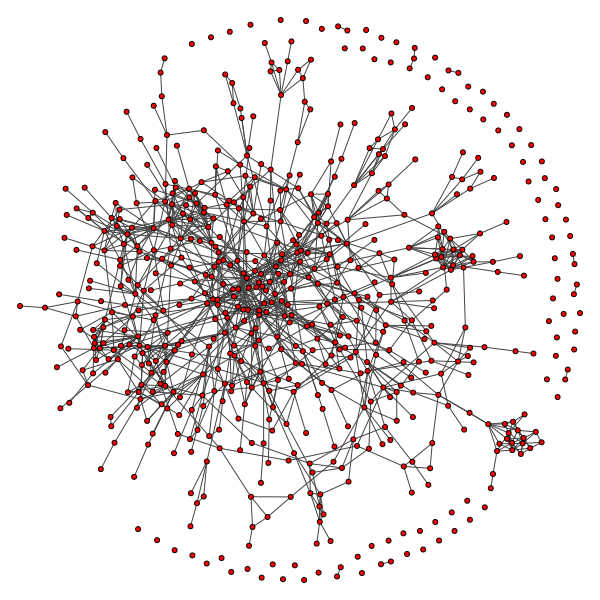

In [9]:
import igraph
import numpy as np

g = igraph.Graph.DataFrame(edge_table[["src", "trg"]], directed=False)
igraph.plot(g, vertex_size=5)

# From edge table to adjacency matrix

While the edge table is simple, it is not a convenient format when it comes to computing. A more convenient format is the **adjacency matrix**. It is a square matrix, where each $(i,j)$ entry represents the presence $A_{ij}=1$ or absence $A_{ij}=0$ of edges.

In [12]:
# Assignment
# - Create an adjacency matrix (`A` as a numpy 2D array ) from the edge table.
# - A[i,j] (and A[j,i]) are the `weight` in the edge table, meaning they represent the number of edges between nodes i and j
# - Make sure A[i,j] = A[j,i]

src = edge_table["src"].values
trg = edge_table["trg"].values
# Or you can simply write
# > src, trg = tuple(edge_table[["src", "trg"]].values.T)

n_nodes = node_table.shape[0]
A = np.zeros(
    (n_nodes, n_nodes)
)  # This will create an n_nodes x n_nodes array with all entry values being zero

# Write your code from here ---

A[src, trg] = 1
A[trg, src] = 1
np.sum(A)


2382.0

In [11]:
# Test
def is_equivalent_network(A, edge_table):
    if np.min(A) != 0:
        return False
    if A.sum() != 2 * edge_table.shape[0]:
        return False
    if np.any(A[tuple(edge_table[["src", "trg"]].values.T)] != 1):
        return False
    return True


assert np.all(
    A == A.T
)  # make sure that A[i,j] = A[j,i] (the adjacency matrix is symmetric)
assert is_equivalent_network(A, edge_table)

The adjacency matrix is a powerful representation that is convenient for computation.  For example, the number of friends for a node (i.e., degree in network terminology) can be computed by
taking a row sum:

In [12]:
node_id = 1
np.sum(A[node_id, :])

8.0

and the degrees of all nodes can be computed by

In [13]:
deg = A.sum(
    axis=1
)  # this will sum the entry values along the column. This will create a 2D array with 1 column.
deg = deg.ravel()  # `.ravel` flatten 2D into 1D array.
deg

array([ 8.,  8.,  1.,  7.,  1.,  0.,  5.,  1.,  3.,  1.,  6.,  8.,  2.,
        0.,  1.,  1.,  3.,  4.,  0.,  3.,  8.,  5.,  6.,  5.,  7.,  0.,
        0.,  9.,  4.,  8.,  1.,  5.,  0., 11.,  8.,  0.,  3.,  9.,  1.,
        4.,  7.,  2.,  3.,  6.,  5.,  5.,  0.,  0., 10.,  3.,  2.,  5.,
        3.,  0.,  0.,  0.,  4.,  0.,  3.,  7.,  3.,  9.,  7.,  6.,  2.,
        5.,  6.,  2.,  3.,  4.,  0.,  3.,  4.,  0.,  1.,  3.,  2.,  6.,
        4.,  7.,  4.,  3.,  1.,  6.,  2.,  2.,  8.,  2.,  0.,  2.,  2.,
        0.,  0.,  5.,  1.,  1.,  3.,  7.,  9.,  1.,  4.,  5.,  3.,  3.,
        0.,  2.,  3.,  1.,  1.,  3.,  1.,  7.,  7.,  2.,  5.,  6.,  3.,
        5.,  2.,  3.,  1.,  6.,  0.,  9.,  8.,  1.,  2.,  0.,  5.,  2.,
        1.,  1.,  0.,  3., 10.,  5.,  1.,  8.,  4.,  1.,  4.,  2.,  2.,
        1.,  7.,  2.,  5.,  9.,  2., 17.,  2.,  7., 11.,  7.,  5.,  4.,
        2.,  0.,  3.,  2.,  7.,  3.,  7.,  2.,  2.,  3.,  2.,  0.,  5.,
        8.,  2.,  2.,  1.,  1.,  1.,  9.,  2.,  1.,  5.,  4.,  1

# Testing the Friendship paradox

We are now ready to test the friendship paradox.

In [14]:
# Assignment
# 1. Compute the average number of friends
# 2. Compute the average number of friends that individual nodes' friends have
# 3. Compare the two values and confirm the friendship paradox
#
#
# Hint:
# Create two lists. One list contains the IDs of individual nodes. The other list contains the IDs of each node's friends.
# The first list does not contain duplicated IDs. But the second list should have duplicated IDs, since a friend can be a friend of another node.
# Then, compute the average degree of the nodes in each list.

individuals = node_table['node_id'].values
_, friends = np.where(A == 1)

ave_num_friends = np.mean([deg[d] for d in individuals])
ave_mum_friends_of_friends = np.mean([deg[d] for d in friends])

ave_num_friends, ave_mum_friends_of_friends

# Friendship paradox confirmed: On average, friends have more friends (6.29) than individuals have (3.67)

(3.670261941448382, 6.290512174643157)

Did you confirm the friendship paradox?

An interesting fact about the friendship paradox is that it is always true no matter how the nodes are connected unless everyone has exactly the same number of friends.

So why does the friendship paradox arise? When we pick a friend of a node, we essentially traverse an edge from the node, and most edges are connected to popular individuals (hubs), since they hold most edges in the network. In other words, popular individuals tend to appear the friend list of many people, and these popular individuals are counted multiple times, when computing the degree of friends, resulting in the friendship paradox.

# Efficient representation for sparse networks
## Coordinate list and adjacency list

While the adjacency matrix is convenient, it is a computationally redundant and expensive representation. Let's take a look at the adjacency matrix.

In [15]:
# Print the adjacency matrix
import sys

np.set_printoptions(threshold=sys.maxsize)
A

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

As you can see, only few entries have value one, while most entries have zero values. The adjacency matrix is a *redundant* representations; it has $n \times n$ values, few of which indicates the presence of edges. The number of values increases quadratically and can quickly exceeds the memory.

The edge table is in fact an efficient representation, since it keeps only the elements of non-zero values.
An edge table is also called *coordinate list*, since the `src`, `trg` can be regarded as a coordinate of non-zero entries of the adjacency matrix.

In [16]:
edge_table

,src,trg
0,10,1
1,12,11
2,22,16
3,24,22
4,33,10
...,...,...
1186,647,473
1187,647,622
1188,648,20
1189,648,145


Another efficient representation is the adjacency list representation. It is a dictionary with keys being nodes. Each value associated with a key is a list of neighbor node IDs.

This representation is also known as the dictionary of keys (DOK) or list-of-list (LIL).

## Compressed sparse row/column

![](https://matteding.github.io/images/csr.gif)

Compressed Sparse Row (CSR) is a highly efficient representation of a sparse matrix. Its main concept revolves around concatenating the adjacency list. Here's how it works: let's say we have an adjacency matrix.

In [17]:
[[0, 1, 1, 1], [1, 0, 1, 0], [1, 1, 0, 1], [1, 0, 1, 0]]

[[0, 1, 1, 1], [1, 0, 1, 0], [1, 1, 0, 1], [1, 0, 1, 0]]

The adjacency list of the matrix is

In [18]:
{
    0: [1, 2, 3],  # neighbors of node 0
    1: [0, 2],  # neighbors of node 1
    2: [0, 1, 3],  # neighbors of node 2
    3: [0, 2],  # neighbors of node 3
}

{0: [1, 2, 3], 1: [0, 2], 2: [0, 1, 3], 3: [0, 2]}

Now, let's talk about the CSR matrix.
The CSR matrix representation consists of three arrays, i.e., `indices`, `indptr`, and `data`. The `indices` is formed by combining the lists into a single list.
$$
\begin{align}
\text{indices}:=[\underbrace{1,2,3}_{\text{node 0}},\underbrace{0,2}_{\text{node 1}},\underbrace{0,1,3}_{\text{node 2}},\underbrace{0,2}_{\text{node 3}}]
\end{align}
$$
The array `indices` consists of $n=4$ subarrays, with each subarray representing the neighbors of a specific node. Additionally, there is another array called `indptr` that indicates the partitioning of the
`indices` array.
$$
\begin{align}
\text{indptr}:=[0,3,5,8,10]
\end{align}
$$
The `indptr` array indicates the starting indices of each subarray. For example, `indptr[0]` indicates the index from which the neighbors of node 0 are listed, and `indptr[1]` indicates another index from which the neighbors of node 1 is listed.

If the sparse matrix is not a binary matrix, meaning the entries of the matrix can take values other than 0 and 1, the CSR representation also includes a `data` array that contains the entry values. The `data` array is divided into subarrays in the same manner as the `indices` array. For example, `data[0]` represents the weight of the edge to the neighbor `indices[0]`.

With that, let's create the CSR representation of the network. Let's first create the adjacency list.

In [19]:
# Assignment:
# Create the adjacency list (with a dictionary named adjList) of the network of the students.
# adjList = {
#   0: [...]
#   1: [...]
#   2: [...]
#   ....
# }

# Your code here ----

adjList = { i: np.where(A[i, :] == 1)[0] for i in node_table['node_id'] }


In [20]:
# Test if the adjList represents the same newtork constructed from the edge table
src, trg = [], []
for i, cols in adjList.items():
    src += [i] * len(cols)
    trg += list(cols)
src, trg = np.array(src), np.array(trg)

a = set(tuple(zip(np.maximum(src, trg), np.minimum(src, trg))))
src, trg = tuple(edge_table[["src", "trg"]].values.T)
b = set(tuple(zip(np.maximum(src, trg), np.minimum(src, trg))))
assert a == b

Then, create the CSR representation.

In [21]:
# Assignment:
# Create the CSR representation of the network.

index_lists = [ cols for i, cols in adjList.items() ]   

indices = np.concatenate(index_lists)
indptr = np.cumsum([ i.size for i in index_lists ])
indptr = np.insert(indptr, 0, 0)  # don't forget the first element 0

In [22]:
# Test if the CSR representation creates the same network
from scipy import sparse

As = sparse.csr_matrix((np.ones_like(indices), indices, indptr), shape=A.shape)
assert np.all(A == As.toarray())

CSR matrix is useful in finding the neighbors of a specific node, just like the adjacency list. For instance,
the neighbors of node 10 is given by

In [23]:
node_id = 10
indices[indptr[node_id] : indptr[node_id + 1]]

array([  1,  33, 181, 503, 622, 647])

Why it works? Let's break down the second line.
The variable

In [24]:
indices

array([114, 191, 202, 237, 352, 423, 564, 619,  10,  97, 103, 149, 259,
       296, 442, 600, 362, 146, 153, 321, 388, 424, 505, 547, 430,  80,
       298, 410, 458, 477, 378,  67, 573, 638, 337,   1,  33, 181, 503,
       622, 647,  12, 305, 330, 462, 487, 577, 624, 642,  11, 332, 353,
       317,  22,  98, 252, 178, 179, 329, 460,  84, 194, 310, 149, 196,
       345, 439, 483, 500, 584, 648,  48, 111, 383, 401, 554,  16,  24,
       252, 292, 364, 615, 182, 221, 249, 321, 351,  22, 115, 126, 134,
       414, 431, 615, 165, 268, 277, 333, 347, 376, 518, 601, 606, 233,
       337, 379, 613,  42,  52, 135, 193, 391, 396, 400, 420, 311,  40,
        83, 208, 311, 327,  10,  48, 209, 246, 265, 280, 356, 542, 586,
       598, 647,  52, 124, 193, 390, 400, 420, 474, 548, 365, 466, 611,
        43,  75, 103, 305, 342, 443, 487, 533, 623, 262,  40, 301, 359,
       398,  31,  39, 168, 208, 320, 434, 476, 259, 470,  29, 135, 400,
        37, 133, 251, 361, 560, 623,  76, 149, 259, 296, 407,  6

is an array consisting of subarrays. And each subarray is associated with a row of the adjacency matrix and consists of column IDs with non-zero entry values for the row.
The subarrays are partitioned by

In [25]:
indptr

array([   0,    8,   16,   17,   24,   25,   25,   30,   31,   34,   35,
         41,   49,   51,   51,   52,   53,   56,   60,   60,   63,   71,
         76,   82,   87,   94,   94,   94,  103,  107,  115,  116,  121,
        121,  132,  140,  140,  143,  152,  153,  157,  164,  166,  169,
        175,  180,  185,  185,  185,  195,  198,  200,  205,  208,  208,
        208,  208,  212,  212,  215,  222,  225,  234,  241,  247,  249,
        254,  260,  262,  265,  269,  269,  272,  276,  276,  277,  280,
        282,  288,  292,  299,  303,  306,  307,  313,  315,  317,  325,
        327,  327,  329,  331,  331,  331,  336,  337,  338,  341,  348,
        357,  358,  362,  367,  370,  373,  373,  375,  378,  379,  380,
        383,  384,  391,  398,  400,  405,  411,  414,  419,  421,  424,
        425,  431,  431,  440,  448,  449,  451,  451,  456,  458,  459,
        460,  460,  463,  473,  478,  479,  487,  491,  492,  496,  498,
        500,  501,  508,  510,  515,  524,  526,  5

For instance,

In [26]:
indices[indptr[10] : indptr[10 + 1]]

array([  1,  33, 181, 503, 622, 647])

is a subarray associated with the 12th row (and thus node 10), which contains the column IDs of the non-zero entries.